
# Gradient Boosting Models

Evaluate multiple gradient boosting approaches (GradientBoosting, HistGradientBoosting, AdaBoost) with tuned hyperparameters and consistent preprocessing.


# Load Libraries

In [ ]:
# Optional: install extra boosting libraries (uncomment if needed)
# !pip install -q xgboost catboost


In [8]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# Optional boosted tree libraries
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None
try:
    from catboost import CatBoostClassifier
except ImportError:
    CatBoostClassifier = None

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

RANDOM_STATE = 28
DATA_DIR = Path('.')
TARGET = 'Churn'
ID_COL = 'ID'
N_ITER = 50  # randomized search iterations
SEARCH_MODE = 'grid'  # 'grid' or 'random'


# Load Data and Create Features

In [9]:

def load_data():
    train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
    test_df = pd.read_csv(DATA_DIR / 'test_data.csv')
    train_df[TARGET] = train_df[TARGET].map({'Yes': 1, 'No': 0})
    return train_df, test_df


def feature_engineer(train_df, test_df):
    reference_date = pd.Timestamp('2024-01-01')
    for df in (train_df, test_df):
        df['DateOfServiceStart'] = pd.to_datetime(df['DateOfServiceStart'])
        df['AccountAgeYears'] = (reference_date - df['DateOfServiceStart']).dt.days / 365
        # df['PricePerGB'] = df['MonthlyCharges'] / df['DataUsagePerMonth']
        # df['ContractType_Monthly'] = (df['ContractType'] == 'Monthly').astype(int)
        # df['ContractType_1_Year'] = (df['ContractType'] == '1-Year').astype(int)
        # df['ServiceType_FiberOptic'] = (df['ServiceType'] == 'Fiber Optic').astype(int)
        df['Autopay'] = df['Autopay'].map({'Yes': 1, 'No': 0})
        df.drop(columns=['DateOfServiceStart'], inplace=True) #, 'ContractType', 'ServiceType', 'PaymentMethod'

    # Preserve test IDs; fallback to index if missing
    test_ids = test_df[ID_COL].copy() if ID_COL in test_df.columns else pd.Series(test_df.index, name='ID')

    drop_cols_train = [TARGET]
    drop_cols_test = []
    if ID_COL in train_df.columns:
        drop_cols_train.append(ID_COL)
    if ID_COL in test_df.columns:
        drop_cols_test.append(ID_COL)

    train_features = train_df.drop(columns=drop_cols_train)
    test_features = test_df.drop(columns=drop_cols_test)

    train_features = pd.get_dummies(train_features, drop_first=False) #, columns=['PaymentMethod']
    test_features = pd.get_dummies(test_features, drop_first=False) #, columns=['PaymentMethod']

    # Align to ensure identical columns between train and test
    train_features, test_features = train_features.align(test_features, join='left', axis=1, fill_value=0)

    X = train_features.copy()
    y = train_df[TARGET]
    X_test = test_features.copy()
    return X, y, X_test, test_ids


In [10]:
# Load and engineer features
train_df, test_df = load_data()
X_full, y_full, X_test, test_ids = feature_engineer(train_df, test_df)

print('Training shape:', X_full.shape)
print('Test (future predictions) shape:', X_test.shape)


Training shape: (1948, 37)
Test (future predictions) shape: (486, 37)


/tmp/ipython-input-1037914924.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateOfServiceStart'] = pd.to_datetime(df['DateOfServiceStart'])



# Exploratory Data Analysis


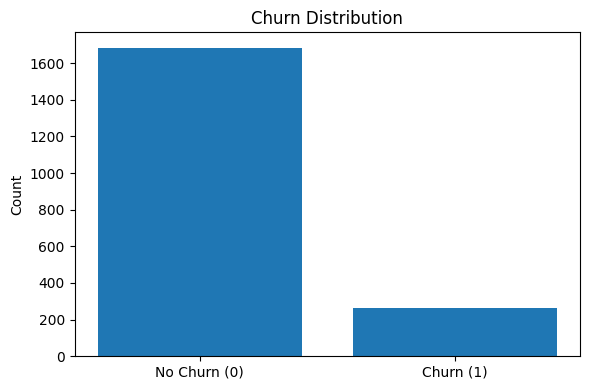

In [11]:
# === Exploratory Data Analysis for Poster ===

# Target distribution
class_counts = train_df[TARGET].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.bar(['No Churn (0)', 'Churn (1)'], class_counts.values)
plt.title("Churn Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Numeric columns used for histograms: ['MonthlyCharges', 'ServiceCalls', 'DataUsagePerMonth', 'CustomerAge', 'AccountAgeYears']


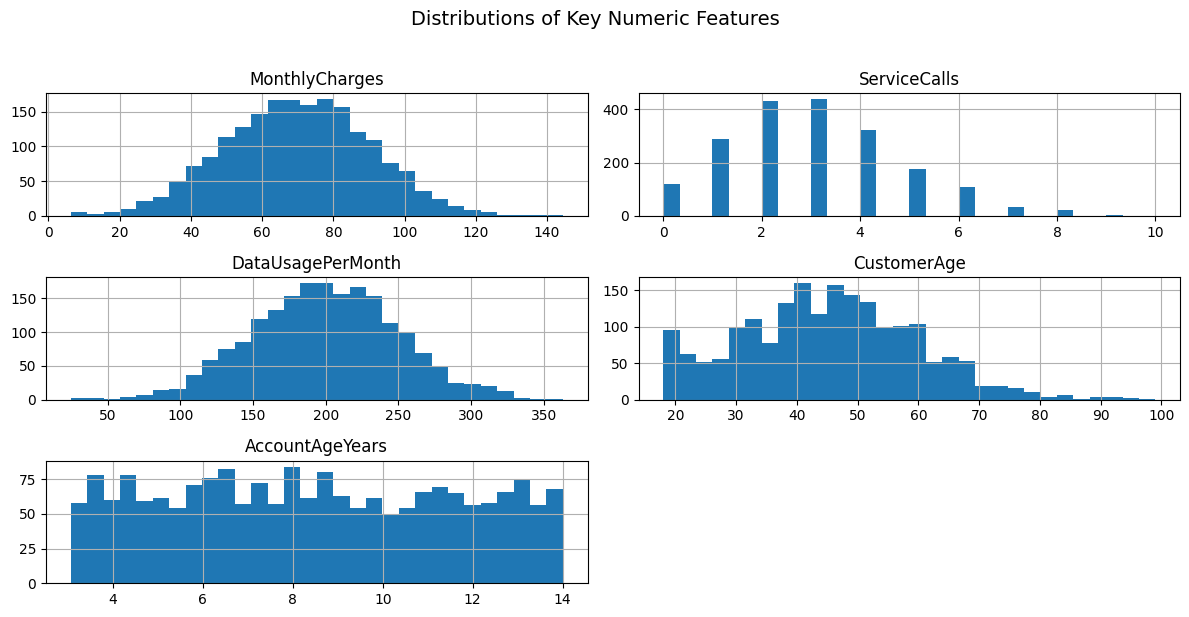

In [12]:
# === Exploratory Data Analysis for Poster ===

# Distributions for key numeric features (adjust list as needed)
candidate_num_cols = [
    'MonthlyCharges',
    'ServiceCalls',
    'DataUsagePerMonth',
    'CustomerAge',
    'AccountAgeYears',
]

num_cols_available = [c for c in candidate_num_cols if c in train_df.columns]
print("Numeric columns used for histograms:", num_cols_available)

train_df[num_cols_available].hist(bins=30, figsize=(12, 6))
plt.suptitle("Distributions of Key Numeric Features", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


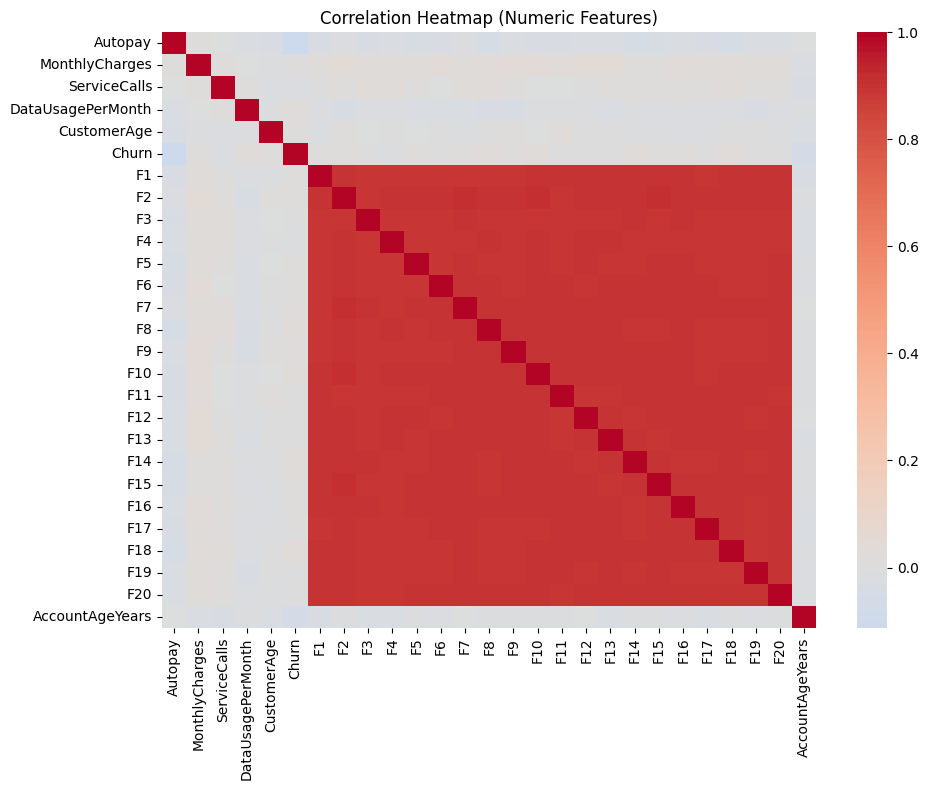

In [13]:
# === Exploratory Data Analysis for Poster ===

# Correlation heatmap for numeric features
num_cols_all = train_df.select_dtypes(include=[np.number, bool]).columns.tolist()
corr = train_df[num_cols_all].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


In [14]:
X_full.head()

,Autopay,MonthlyCharges,ServiceCalls,DataUsagePerMonth,CustomerAge,F1,F2,F3,F4,F5,...,ContractType_2-Year,ContractType_Monthly,PaymentMethod_Bank Transfer,PaymentMethod_Check,PaymentMethod_Credit Card,ServiceType_DSL1,ServiceType_DSL2,ServiceType_DSL3,ServiceType_Fiber Optic,ServiceType_Other
0,0,66.94,4,244.95,18,-0.389922,0.480638,0.277729,0.041507,-0.118071,...,False,True,False,False,True,False,False,False,True,False
1,1,38.03,0,183.65,41,-1.560211,-1.329809,-1.334561,-1.122284,-1.868390,...,False,False,True,False,False,True,False,False,False,False
2,1,84.21,4,181.32,43,0.090687,-0.316364,-0.082004,0.048963,-0.228050,...,False,True,False,False,True,False,False,False,True,False
3,1,62.14,3,196.87,40,1.215128,NaN,1.053684,1.100996,1.316259,...,True,False,True,False,False,False,False,False,False,True
4,0,70.02,2,154.33,54,0.752764,0.916246,1.084516,NaN,-0.073793,...,False,True,False,True,False,False,False,False,True,False


# Hyperparameter Tuning using Cross Validation


In [15]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

def run_search(name, estimator, param_options):
    """Run CV using GridSearchCV or RandomizedSearchCV based on SEARCH_MODE."""
    if estimator is None:
        print(f"{name}: estimator not available (missing dependency). Skipping.")
        return None

    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', estimator),
    ])

    if SEARCH_MODE == 'random':
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_options,
            n_iter=N_ITER,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            random_state=RANDOM_STATE,
            refit=True,
            verbose=1
        )
    else:
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_options,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            refit=True,
            verbose=1
        )

    search.fit(X_full, y_full)
    results.append({'model': name, 'best_auc': search.best_score_, 'best_params': search.best_params_})
    best_models[name] = search
    print(f"{name}: {search.best_score_:.4f} AUC")
    return search


## Random Search CV - Iteration 1

In [ ]:
results = []
best_models = {}

# XGBoost grid search around best found params (if available)
if XGBClassifier is not None:
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=RANDOM_STATE,
        tree_method='hist',
        n_jobs=-1,
    )
    xgb_random_grid = {
        'imputer': [SimpleImputer(strategy='median'), KNNImputer(n_neighbors=5), KNNImputer(n_neighbors=25)],
        'model__n_estimators': np.arange(100, 2000, 200),
        'model__learning_rate': [0.0001,0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3],
        'model__max_depth': np.arange(1, 20, 2), # [1, 3, 5, 7, 10, 15]
        'model__min_child_weight': [1, 2, 3, 5, 8, 10, 12], #[1, 3, 7, 10, 12]
        'model__subsample': [0.9],
        'model__colsample_bytree': [0.8, 0.85, 0.9],
        # 'model__gamma': [0, 1, 3, 6, 8, 10],
        # 'model__reg_alpha': [0, 0.1, 0.5, 1, 2, 4],
        # 'model__reg_lambda': [0, 0.5, 1, 2, 5],
    }

    SEARCH_MODE = 'random'
    xgb_search = run_search('xgboost', xgb, xgb_random_grid)


else:
    print('XGBoost not installed; skipping.')


# Results summary
results_df = (
    pd.DataFrame(results)
    .sort_values('best_auc', ascending=False)
    .reset_index(drop=True)
)
results_df

Fitting 10 folds for each of 50 candidates, totalling 500 fits
xgboost: 0.6787 AUC


,model,best_auc,best_params
0,xgboost,0.678687,"{'model__subsample': 0.9, 'model__n_estimators..."


In [ ]:
# Convert cv_results_ to a DataFrame
xgb_cv_df = pd.DataFrame(xgb_search.cv_results_)

# Keep only the useful columns
cols_to_show = [
    'mean_test_score',
    'std_test_score',
    'param_imputer',
    'param_model__n_estimators',
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__min_child_weight',
    'param_model__subsample',
    'param_model__colsample_bytree',
    # 'param_model__gamma',
    # 'param_model__reg_alpha',
    # 'param_model__reg_lambda',
]

xgb_cv_df = xgb_cv_df[cols_to_show].sort_values('mean_test_score', ascending=False)

# Show top 10 configurations
xgb_cv_df['1std_test_score'] = xgb_cv_df['mean_test_score'] - xgb_cv_df['std_test_score']
xgb_cv_df.sort_values('1std_test_score', ascending=False).head(10)


,mean_test_score,std_test_score,param_imputer,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__min_child_weight,param_model__subsample,param_model__colsample_bytree,1std_test_score
36,0.678687,0.030793,SimpleImputer(strategy='median'),900,0.0005,1,1,0.9,0.85,0.647894
43,0.678598,0.031469,SimpleImputer(strategy='median'),1900,0.0005,1,12,0.9,0.80,0.647129
49,0.668917,0.038894,KNNImputer(),300,0.0001,3,10,0.9,0.80,0.630023
19,0.664240,0.035453,SimpleImputer(strategy='median'),100,0.0001,1,12,0.9,0.80,0.628787
3,0.670192,0.045024,SimpleImputer(strategy='median'),100,0.0010,5,12,0.9,0.85,0.625167
45,0.669480,0.046860,KNNImputer(),900,0.0001,3,1,0.9,0.85,0.622620
41,0.663069,0.040731,SimpleImputer(strategy='median'),900,0.0100,1,1,0.9,0.80,0.622338
33,0.669217,0.047036,KNNImputer(),1300,0.0001,3,1,0.9,0.90,0.622180
23,0.666843,0.045346,SimpleImputer(strategy='median'),300,0.0010,17,12,0.9,0.90,0.621497
16,0.654833,0.039588,KNNImputer(),1900,0.0005,15,10,0.9,0.80,0.615244


## Random Search CV - Iteration 2

In [ ]:
results = []
best_models = {}

# XGBoost grid search around best found params (if available)
if XGBClassifier is not None:
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=RANDOM_STATE,
        tree_method='hist',
        n_jobs=-1,
    )
    xgb_random_grid = {
        'imputer': [SimpleImputer(strategy='median')], #KNNImputer(n_neighbors=5), KNNImputer(n_neighbors=25)
        'model__n_estimators': [100, 300, 900, 1700],
        'model__learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05], # [0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3],
        'model__max_depth': [1, 3, 5, 10, 15],
        'model__min_child_weight': [1, 3, 5, 10, 15],
        'model__subsample': [0.9], #np.arange(0.75, 0.95, 0.05)
        'model__colsample_bytree': [0.80], #np.arange(0.75, 0.9, 0.05)
        'model__gamma': [0, 2, 6, 8, 10, 12],
        'model__reg_alpha': [0, 0.5, 1, 2, 4],
        'model__reg_lambda':  [0.2, 0.5, 1, 2, 4]
    }

    SEARCH_MODE = 'random'
    xgb_search = run_search('xgboost', xgb, xgb_random_grid)


else:
    print('XGBoost not installed; skipping.')


# Results summary
results_df = (
    pd.DataFrame(results)
    .sort_values('best_auc', ascending=False)
    .reset_index(drop=True)
)
results_df


Fitting 10 folds for each of 50 candidates, totalling 500 fits
xgboost: 0.6867 AUC


,model,best_auc,best_params
0,xgboost,0.686665,"{'model__subsample': 0.9, 'model__reg_lambda':..."


In [ ]:
# Convert cv_results_ to a DataFrame
xgb_cv_df = pd.DataFrame(xgb_search.cv_results_)

# Keep only the useful columns
cols_to_show = [
    'mean_test_score',
    'std_test_score',
    'param_imputer',
    'param_model__n_estimators',
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__min_child_weight',
    'param_model__subsample',
    'param_model__colsample_bytree',
    'param_model__gamma',
    'param_model__reg_alpha',
    'param_model__reg_lambda',
]

xgb_cv_df = xgb_cv_df[cols_to_show].sort_values('mean_test_score', ascending=False)

# Show top 10 configurations
xgb_cv_df['1std_test_score'] = xgb_cv_df['mean_test_score'] - xgb_cv_df['std_test_score']
xgb_cv_df.sort_values('1std_test_score', ascending=False).head(10)


,mean_test_score,std_test_score,param_imputer,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__min_child_weight,param_model__subsample,param_model__colsample_bytree,param_model__gamma,param_model__reg_alpha,param_model__reg_lambda,1std_test_score
21,0.686421,0.030874,SimpleImputer(strategy='median'),300,0.010,15,10,0.9,0.8,10,4.0,0.5,0.655547
28,0.686402,0.031248,SimpleImputer(strategy='median'),300,0.010,10,10,0.9,0.8,12,2.0,0.2,0.655154
12,0.686665,0.031556,SimpleImputer(strategy='median'),900,0.005,3,5,0.9,0.8,10,4.0,1.0,0.655109
16,0.684322,0.029806,SimpleImputer(strategy='median'),900,0.050,5,5,0.9,0.8,12,4.0,2.0,0.654517
33,0.686344,0.032663,SimpleImputer(strategy='median'),300,0.005,3,10,0.9,0.8,12,2.0,0.2,0.653680
26,0.685031,0.032403,SimpleImputer(strategy='median'),900,0.001,15,3,0.9,0.8,12,2.0,4.0,0.652628
31,0.684640,0.032084,SimpleImputer(strategy='median'),300,0.005,5,3,0.9,0.8,10,2.0,4.0,0.652556
4,0.681969,0.030484,SimpleImputer(strategy='median'),1700,0.001,1,3,0.9,0.8,8,4.0,0.2,0.651485
19,0.682079,0.032334,SimpleImputer(strategy='median'),900,0.001,15,15,0.9,0.8,10,1.0,2.0,0.649745
9,0.685416,0.035747,SimpleImputer(strategy='median'),1700,0.050,3,15,0.9,0.8,12,0.5,0.2,0.649668


## Random Search CV - Iteration 3

In [ ]:
N_ITER = 100
results = []
best_models = {}

# XGBoost grid search around best found params (if available)
if XGBClassifier is not None:
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=RANDOM_STATE,
        tree_method='hist',
        n_jobs=-1,
    )
    xgb_random_grid = {
        'imputer': [SimpleImputer(strategy='median'), KNNImputer(n_neighbors=25)],#, KNNImputer(n_neighbors=5),
        'model__n_estimators': [300, 900, 1700],
        'model__learning_rate': [0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1],
        'model__max_depth': [3, 5, 10 , 15],
        'model__min_child_weight': np.arange(5, 16, 2),
        'model__subsample': [0.9],
        'model__colsample_bytree': [0.8],
        'model__gamma': np.linspace(8, 13, 6),
        'model__reg_alpha': np.linspace(2, 5, 6),
        'model__reg_lambda': [0.5, 1, 4]
    }

    SEARCH_MODE = 'random'
    xgb_search = run_search('xgboost', xgb, xgb_random_grid)


else:
    print('XGBoost not installed; skipping.')


# Results summary
results_df = (
    pd.DataFrame(results)
    .sort_values('best_auc', ascending=False)
    .reset_index(drop=True)
)
results_df


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
xgboost: 0.6891 AUC


,model,best_auc,best_params
0,xgboost,0.689092,"{'model__subsample': 0.9, 'model__reg_lambda':..."


In [ ]:
# Convert cv_results_ to a DataFrame
xgb_cv_df = pd.DataFrame(xgb_search.cv_results_)

# Keep only the useful columns
cols_to_show = [
    'mean_test_score',
    'std_test_score',
    'param_imputer',
    'param_model__n_estimators',
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__min_child_weight',
    'param_model__subsample',
    'param_model__colsample_bytree',
    'param_model__gamma',
    'param_model__reg_alpha',
    'param_model__reg_lambda',
]

xgb_cv_df = xgb_cv_df[cols_to_show].sort_values('mean_test_score', ascending=False)

# Show top 10 configurations
xgb_cv_df['1std_test_score'] = xgb_cv_df['mean_test_score'] - xgb_cv_df['std_test_score']
xgb_cv_df.sort_values('mean_test_score', ascending=False).head(10)


,mean_test_score,std_test_score,param_imputer,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__min_child_weight,param_model__subsample,param_model__colsample_bytree,param_model__gamma,param_model__reg_alpha,param_model__reg_lambda,1std_test_score
77,0.689092,0.032348,KNNImputer(n_neighbors=25),900,0.0750,15,7,0.9,0.8,10.0,3.2,4.0,0.656744
79,0.688908,0.030524,KNNImputer(n_neighbors=25),1700,0.1000,5,15,0.9,0.8,10.0,3.8,0.5,0.658383
56,0.688432,0.032555,SimpleImputer(strategy='median'),900,0.0500,5,13,0.9,0.8,8.0,5.0,0.5,0.655877
32,0.688425,0.031185,SimpleImputer(strategy='median'),1700,0.1000,5,13,0.9,0.8,10.0,5.0,0.5,0.657240
20,0.688308,0.035083,SimpleImputer(strategy='median'),1700,0.1000,3,15,0.9,0.8,10.0,2.6,1.0,0.653225
51,0.688162,0.036422,SimpleImputer(strategy='median'),1700,0.1000,5,13,0.9,0.8,10.0,2.0,4.0,0.651740
55,0.687370,0.030751,SimpleImputer(strategy='median'),1700,0.0075,15,5,0.9,0.8,11.0,3.2,0.5,0.656619
28,0.687097,0.031399,KNNImputer(n_neighbors=25),300,0.0500,3,13,0.9,0.8,8.0,4.4,4.0,0.655698
39,0.687060,0.032229,SimpleImputer(strategy='median'),900,0.0750,3,11,0.9,0.8,10.0,5.0,4.0,0.654832
27,0.686987,0.032106,KNNImputer(n_neighbors=25),900,0.0500,15,5,0.9,0.8,10.0,3.2,1.0,0.654881


## Random Search CV - Iteration 4

In [ ]:
N_ITER = 100
results = []
best_models = {}

# XGBoost grid search around best found params (if available)
if XGBClassifier is not None:
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=RANDOM_STATE,
        tree_method='hist',
        n_jobs=-1,
    )
    xgb_random_grid = {
        'imputer': [SimpleImputer(strategy='median'), KNNImputer(n_neighbors=25)],#, KNNImputer(n_neighbors=5),
        'model__n_estimators': [1500],
        'model__learning_rate': [0.05, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13],
        'model__max_depth': [4, 5, 6, 7, 8],
        'model__min_child_weight': [12, 13, 14, 15, 16, 18, 20],
        'model__subsample': [0.9],
        'model__colsample_bytree': [0.8],
        'model__gamma': [8, 10],
        'model__reg_alpha': np.arange(2, 6.1, 0.5),
        'model__reg_lambda': [0.25, 0.5, 0.75, 1, 4]
    }

    SEARCH_MODE = 'random'
    xgb_search = run_search('xgboost', xgb, xgb_random_grid)


else:
    print('XGBoost not installed; skipping.')


# Results summary
results_df = (
    pd.DataFrame(results)
    .sort_values('best_auc', ascending=False)
    .reset_index(drop=True)
)
results_df


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
xgboost: 0.6904 AUC


,model,best_auc,best_params
0,xgboost,0.690397,"{'model__subsample': 0.9, 'model__reg_lambda':..."


In [ ]:
# Convert cv_results_ to a DataFrame
xgb_cv_df = pd.DataFrame(xgb_search.cv_results_)

# Keep only the useful columns
cols_to_show = [
    'mean_test_score',
    'std_test_score',
    'param_imputer',
    'param_model__n_estimators',
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__min_child_weight',
    'param_model__subsample',
    'param_model__colsample_bytree',
    'param_model__gamma',
    'param_model__reg_alpha',
    'param_model__reg_lambda',
]

xgb_cv_df = xgb_cv_df[cols_to_show].sort_values('mean_test_score', ascending=False)

# Show top 10 configurations
xgb_cv_df['1std_test_score'] = xgb_cv_df['mean_test_score'] - xgb_cv_df['std_test_score']
xgb_cv_df.sort_values('1std_test_score', ascending=False).head(10)


,mean_test_score,std_test_score,param_imputer,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__min_child_weight,param_model__subsample,param_model__colsample_bytree,param_model__gamma,param_model__reg_alpha,param_model__reg_lambda,1std_test_score
59,0.687485,0.028064,KNNImputer(n_neighbors=25),1500,0.13,8,13,0.9,0.8,10,4.5,4.00,0.659421
76,0.689191,0.030920,KNNImputer(n_neighbors=25),1500,0.10,8,16,0.9,0.8,10,5.0,0.50,0.658272
1,0.690397,0.032384,SimpleImputer(strategy='median'),1500,0.09,6,20,0.9,0.8,8,5.5,4.00,0.658013
96,0.688389,0.030570,KNNImputer(n_neighbors=25),1500,0.13,6,14,0.9,0.8,10,4.5,0.75,0.657819
10,0.689217,0.031491,SimpleImputer(strategy='median'),1500,0.10,6,15,0.9,0.8,10,4.0,0.50,0.657725
73,0.686327,0.028797,SimpleImputer(strategy='median'),1500,0.13,7,12,0.9,0.8,10,5.5,0.50,0.657530
97,0.686736,0.029435,KNNImputer(n_neighbors=25),1500,0.09,7,18,0.9,0.8,10,4.5,4.00,0.657301
27,0.688398,0.031230,KNNImputer(n_neighbors=25),1500,0.05,8,18,0.9,0.8,10,4.5,0.50,0.657168
28,0.689040,0.031877,KNNImputer(n_neighbors=25),1500,0.10,8,14,0.9,0.8,10,4.0,0.75,0.657163
25,0.688891,0.031745,SimpleImputer(strategy='median'),1500,0.10,6,14,0.9,0.8,10,4.0,1.00,0.657146


## Grid Search CV - Final Model

In [16]:
results = []
best_models = {}

# XGBoost grid search around best found params (if available)
if XGBClassifier is not None:
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=RANDOM_STATE,
        tree_method='hist',
        n_jobs=-1,
    )


    xgb_grid = {
        'imputer': [KNNImputer(n_neighbors=25)], # SimpleImputer(strategy='median'),
        'model__n_estimators': [1500],
        'model__learning_rate': [0.15],
        'model__max_depth': [6],
        'model__min_child_weight': [20],
        'model__subsample': [0.9],
        'model__colsample_bytree': [0.8],
        'model__gamma': [10],
        'model__reg_alpha': [3.75], # 2, 4
        'model__reg_lambda': [0.85], # 0.5
    }

    SEARCH_MODE = 'grid'
    xgb_search = run_search('xgboost', xgb, xgb_grid)

else:
    print('XGBoost not installed; skipping.')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
xgboost: 0.6898 AUC


In [17]:
# Convert cv_results_ to a DataFrame
xgb_cv_df = pd.DataFrame(xgb_search.cv_results_)

# Keep only the useful columns
cols_to_show = [
    'mean_test_score',
    'std_test_score',
    'param_imputer',
    'param_model__n_estimators',
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__min_child_weight',
    'param_model__subsample',
    'param_model__colsample_bytree',
    'param_model__gamma',
    'param_model__reg_alpha',
    'param_model__reg_lambda',
]

xgb_cv_df = xgb_cv_df[cols_to_show].sort_values('mean_test_score', ascending=False)

# Show top 10 configurations
xgb_cv_df['1std_test_score'] = xgb_cv_df['mean_test_score'] - xgb_cv_df['std_test_score']
xgb_cv_df.sort_values('mean_test_score', ascending=False).head(25)


,mean_test_score,std_test_score,param_imputer,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__min_child_weight,param_model__subsample,param_model__colsample_bytree,param_model__gamma,param_model__reg_alpha,param_model__reg_lambda,1std_test_score
0,0.689758,0.033845,KNNImputer(n_neighbors=25),1500,0.15,6,20,0.9,0.8,10,3.75,0.85,0.655913


# Use Best Model to make Predictions

In [18]:
# Results summary
results_df = (
    pd.DataFrame(results)
    .sort_values('best_auc', ascending=False)
    .reset_index(drop=True)
)
results_df

,model,best_auc,best_params
0,xgboost,0.689758,"{'imputer': KNNImputer(n_neighbors=25), 'model..."


In [19]:
# Train best model on full training data and predict test set
if results_df.empty:
    raise ValueError('Run searches first.')

best_name = results_df.loc[0, 'model']
best_search = best_models[best_name]
best_model = best_search.best_estimator_

best_model.fit(X_full, y_full)
test_pred = best_model.predict_proba(X_test)[:, 1]

# Feature Importance

Top features:


,feature,importance
0,ContractType_Monthly,0.386043
1,Autopay,0.227244
2,ServiceType_Fiber Optic,0.195417
3,AccountAgeYears,0.191296
4,MonthlyCharges,0.000000
5,CustomerAge,0.000000
6,DataUsagePerMonth,0.000000
7,ServiceCalls,0.000000
8,F1,0.000000
9,F5,0.000000


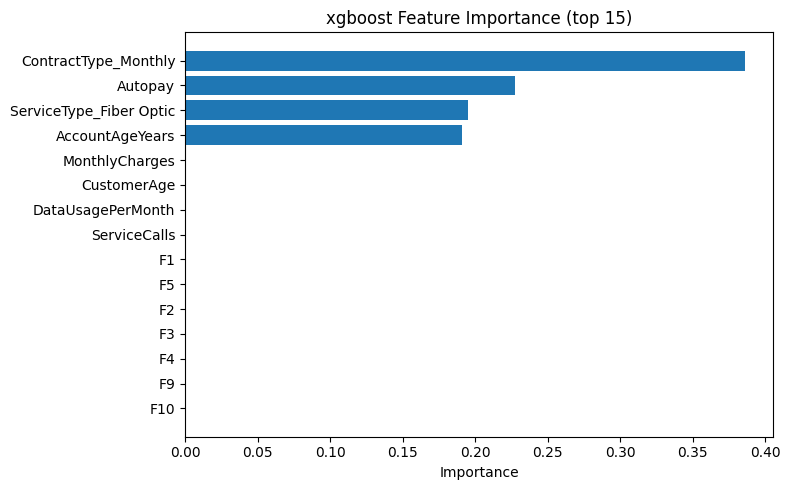

In [20]:
# Feature importance for tree-based models (if available)
est = best_model.named_steps['model']
if hasattr(est, 'feature_importances_'):
    importances = est.feature_importances_
    feature_names = X_full.columns
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi = fi.sort_values('importance', ascending=False).reset_index(drop=True)
    print('Top features:')
    display(fi)
    plt.figure(figsize=(8, 5))
    plt.barh(fi.head(15)['feature'], fi.head(15)['importance'], color='#1f77b4')
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title(f'{best_name} Feature Importance (top 15)')
    plt.tight_layout()
    plt.show()
else:
    print('Best model has no feature_importances_ attribute.')


# Create Submission

In [21]:
submission = pd.DataFrame({
    'ID': test_ids,
    'ChurnProb': test_pred,
})

out_path = DATA_DIR / 'submission_best_boost.csv'
submission.to_csv(out_path, index=False)
print('Saved submission to', out_path.resolve())
submission.head()


,ID,ChurnProb
0,1,0.117987
1,2,0.091067
2,3,0.212960
3,4,0.085356
4,5,0.212960


# Interpretable Model - Decision Tree

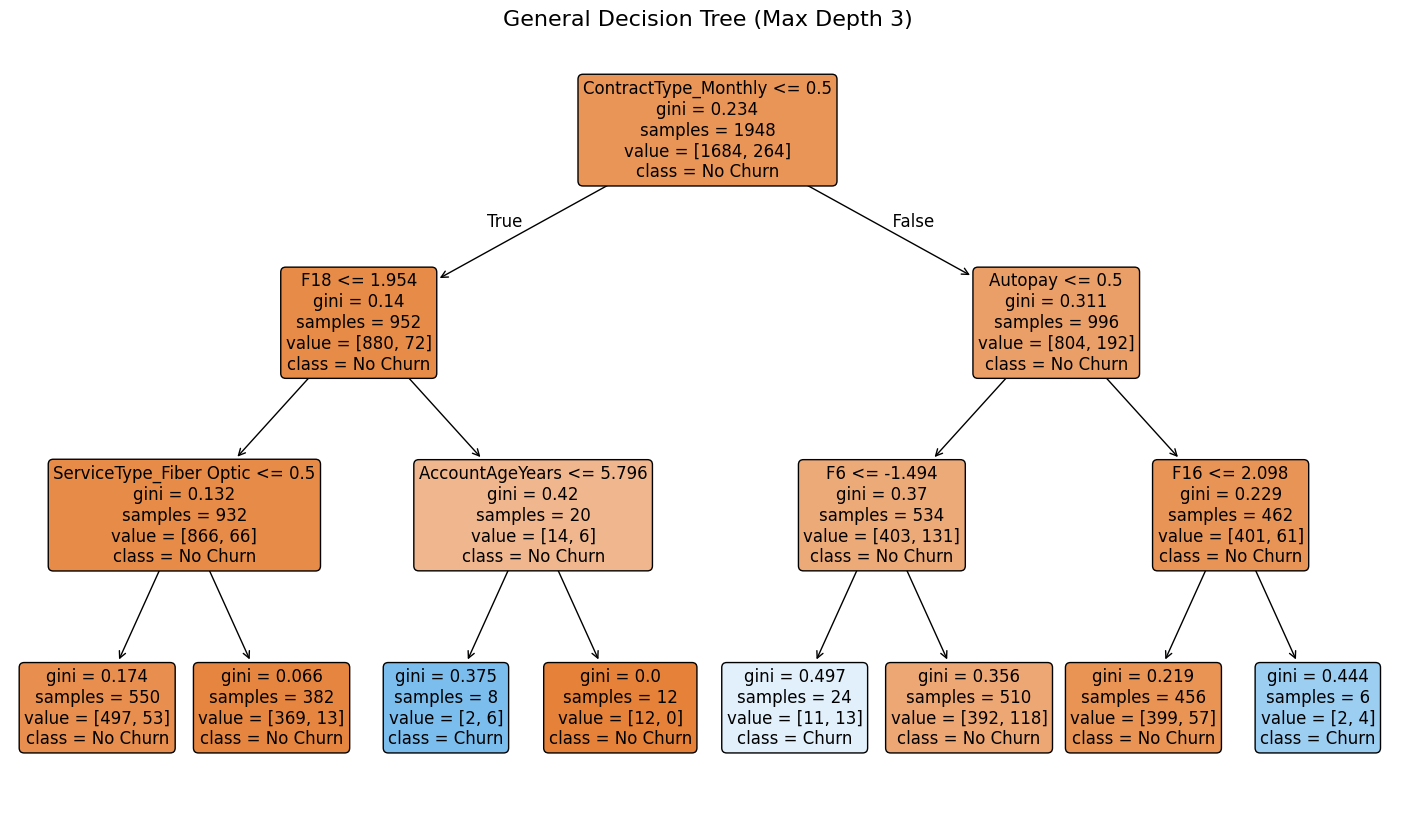

In [22]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1. General Interpretable Decision Tree
# We set a max_depth so the tree remains readable for understanding
dt_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE))
])

dt_model.fit(X_full, y_full)

plt.figure(figsize=(18, 10))
plot_tree(dt_model.named_steps['model'],
          feature_names=X_full.columns,
          class_names=['No Churn', 'Churn'],
          filled=True, rounded=True, fontsize=12)
plt.title("General Decision Tree (Max Depth 3)", fontsize=16)
plt.show()


# Additional Poster Visuals

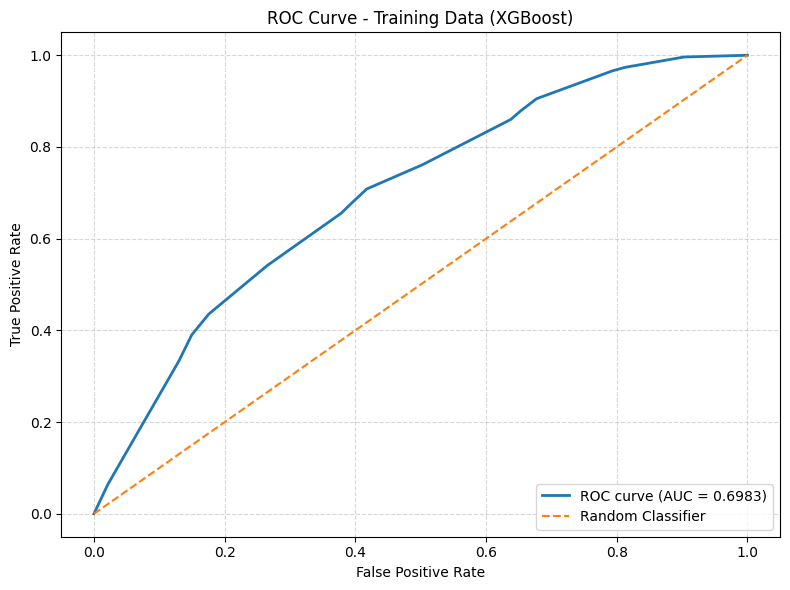

In [23]:
def plot_roc_curve_local(y_true, y_proba, title_suffix):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {title_suffix}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

x_proba = best_model.predict_proba(X_full)[:, 1]
auc_xgb = plot_roc_curve_local(y_full, x_proba, "Training Data (XGBoost)")


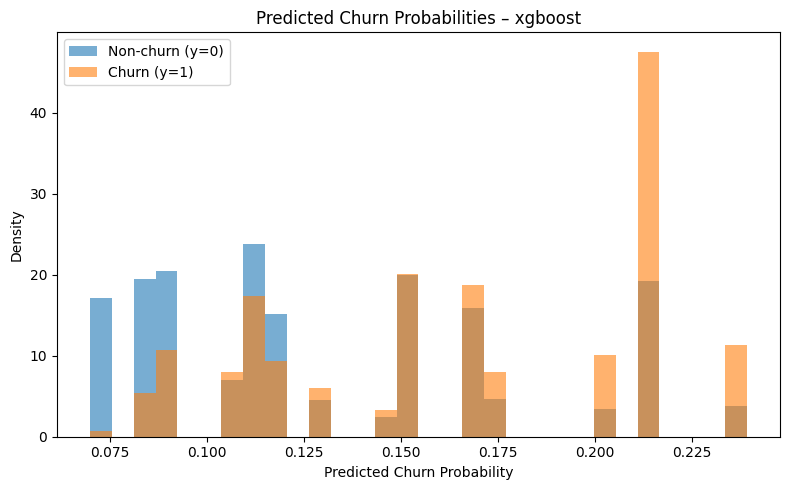

In [24]:
from sklearn.metrics import roc_auc_score

# Ensure we have the best model trained
if "best_model" in globals():
    # Predicted probabilities for the positive class
    y_proba_full = best_model.predict_proba(X_full)[:, 1]

    plt.figure(figsize=(8, 5))
    plt.hist(
        y_proba_full[y_full == 0],
        bins=30,
        alpha=0.6,
        label="Non-churn (y=0)",
        density=True,
    )
    plt.hist(
        y_proba_full[y_full == 1],
        bins=30,
        alpha=0.6,
        label="Churn (y=1)",
        density=True,
    )

    plt.xlabel("Predicted Churn Probability")
    plt.ylabel("Density")
    plt.title(f"Predicted Churn Probabilities – {best_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("best_model not available – run the training cell first.")


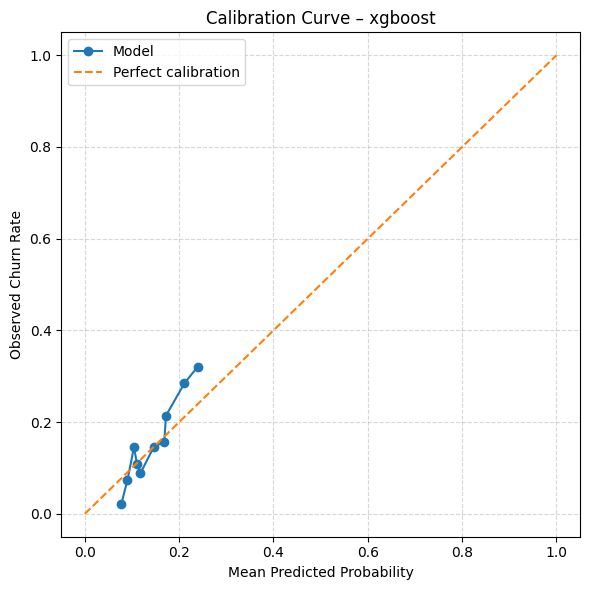

In [25]:
from sklearn.calibration import calibration_curve

if "best_model" in globals():
    y_proba_full = best_model.predict_proba(X_full)[:, 1]

    frac_pos, mean_pred = calibration_curve(y_full, y_proba_full, n_bins=10, strategy="quantile")

    plt.figure(figsize=(6, 6))
    plt.plot(mean_pred, frac_pos, marker="o", label="Model")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")

    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Observed Churn Rate")
    plt.title(f"Calibration Curve – {best_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("best_model not available.")


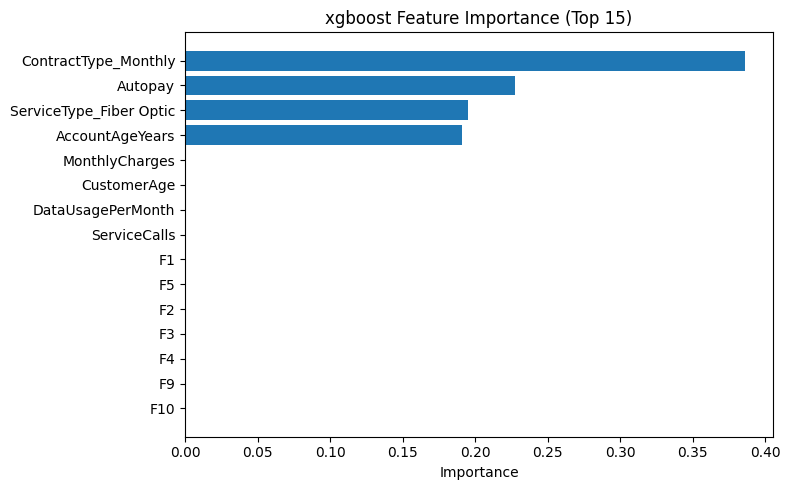

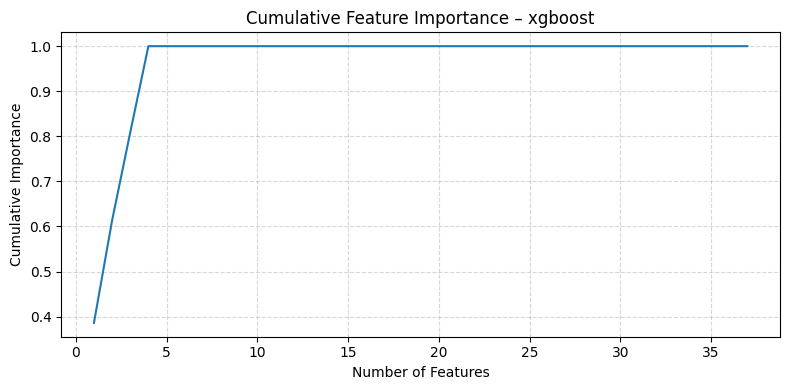

,feature,importance,cum_importance
0,ContractType_Monthly,0.386043,0.386043
1,Autopay,0.227244,0.613288
2,ServiceType_Fiber Optic,0.195417,0.808704
3,AccountAgeYears,0.191296,1.000000
4,MonthlyCharges,0.000000,1.000000
5,CustomerAge,0.000000,1.000000
6,DataUsagePerMonth,0.000000,1.000000
7,ServiceCalls,0.000000,1.000000
8,F1,0.000000,1.000000
9,F5,0.000000,1.000000


In [26]:
if "best_model" in globals():
    est = best_model.named_steps["model"]

    if hasattr(est, "feature_importances_"):
        importances = est.feature_importances_
        feature_names = X_full.columns

        fi = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).sort_values("importance", ascending=False).reset_index(drop=True)

        fi["cum_importance"] = fi["importance"].cumsum()

        # Top 15 bar chart
        top_n = 15
        plt.figure(figsize=(8, 5))
        plt.barh(fi["feature"].head(top_n)[::-1], fi["importance"].head(top_n)[::-1])
        plt.xlabel("Importance")
        plt.title(f"{best_name} Feature Importance (Top {top_n})")
        plt.tight_layout()
        plt.show()

        # Cumulative importance line plot
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(fi) + 1), fi["cum_importance"])
        plt.xlabel("Number of Features")
        plt.ylabel("Cumulative Importance")
        plt.title(f"Cumulative Feature Importance – {best_name}")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

        display(fi.head(25))
    else:
        print("Best model has no feature_importances_.")
else:
    print("best_model not available.")


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

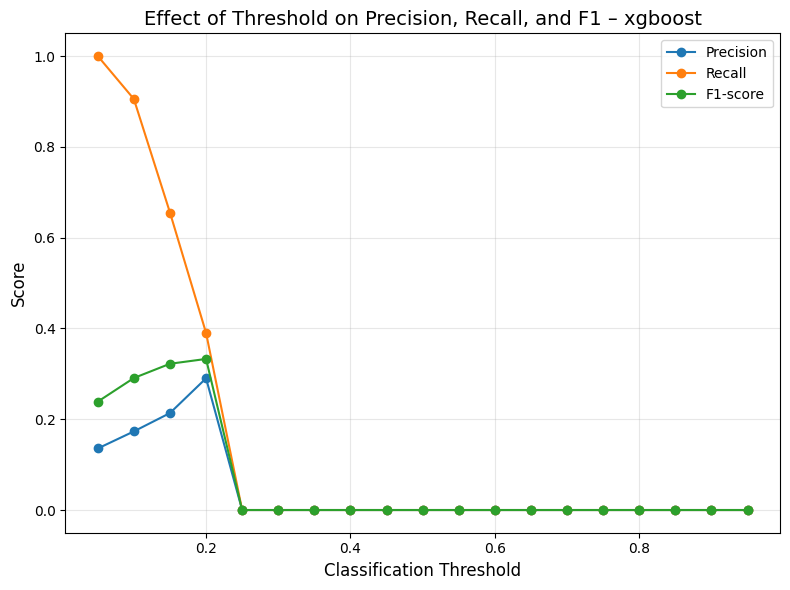

In [27]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_proba = best_model.predict_proba(X_full)[:, 1]

thresholds = np.linspace(0.05, 0.95, 19)

precisions = []
recalls = []
f1s = []

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    precisions.append(precision_score(y_full, y_pred_thr))
    recalls.append(recall_score(y_full, y_pred_thr))
    f1s.append(f1_score(y_full, y_pred_thr))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, marker="o", label="Precision")
plt.plot(thresholds, recalls, marker="o", label="Recall")
plt.plot(thresholds, f1s, marker="o", label="F1-score")

plt.xlabel("Classification Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title(f"Effect of Threshold on Precision, Recall, and F1 – {best_name}", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2378084902.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df.groupby(["prob_bin", "y_true"]).size().unstack(fill_value=0)


<Figure size 900x500 with 0 Axes>

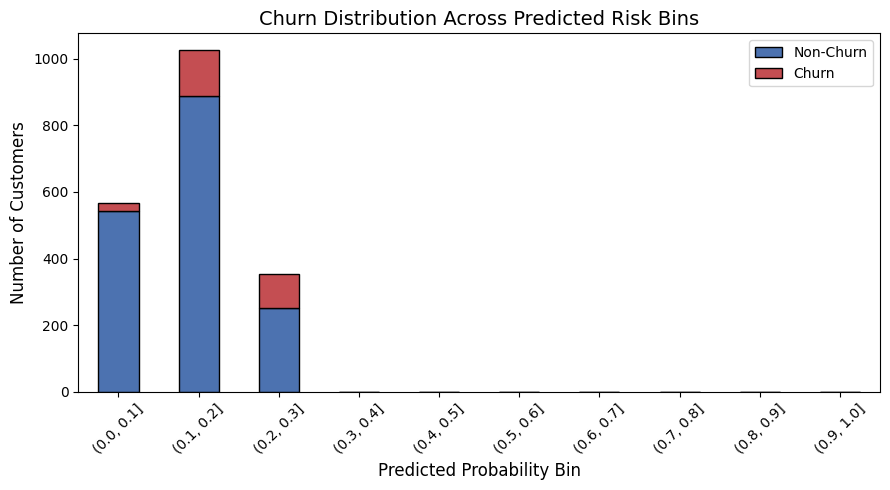

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_proba = best_model.predict_proba(X_full)[:, 1]
df = pd.DataFrame({"y_true": y_full, "y_proba": y_proba})

# Create 10 equal probability bins
df["prob_bin"] = pd.cut(df["y_proba"], bins=np.linspace(0,1,11))

bin_counts = df.groupby(["prob_bin", "y_true"]).size().unstack(fill_value=0)

plt.figure(figsize=(9,5))
bin_counts.plot(
    kind="bar",
    stacked=True,
    color=["#4C72B0", "#C44E52"],
    edgecolor="black",
    figsize=(9,5)
)

plt.xlabel("Predicted Probability Bin", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.title("Churn Distribution Across Predicted Risk Bins", fontsize=14)
plt.xticks(rotation=45)
plt.legend(["Non-Churn", "Churn"], fontsize=10)
plt.tight_layout()
plt.show()


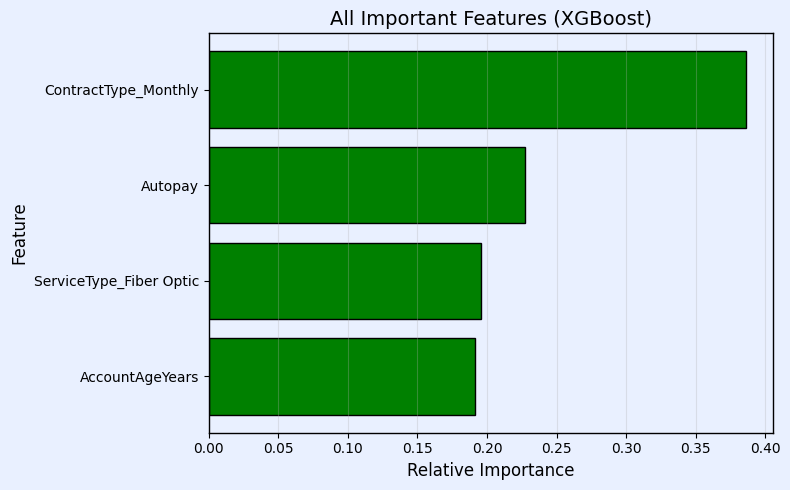

In [29]:
import matplotlib.pyplot as plt

# Create figure + axes with background color
fig, ax = plt.subplots(figsize=(8,5))
fig.set_facecolor("#E9F0FF")   # poster background color
ax.set_facecolor("#E9F0FF")    # axes background

# Bar chart
ax.barh(
    fi["feature"].head(4)[::-1],
    fi["importance"].head(4)[::-1],
    color="green",
    edgecolor="black"
)

# Labels & styling
ax.set_xlabel("Relative Importance", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
ax.set_title("All Important Features (XGBoost)", fontsize=14)

ax.grid(axis="x", alpha=0.3)

# Black outline box around the plot (optional but poster-clean)
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1)

plt.tight_layout()
plt.show()


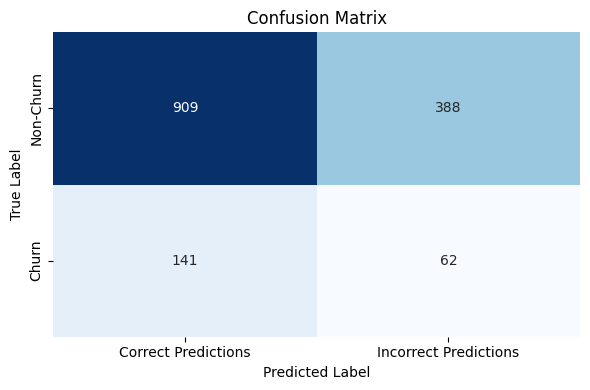

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothetical example — DO NOT label as actual results
cm_example = np.array([
    [909, 388],
    [141,  62]
])

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_example,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Correct Predictions", "Incorrect Predictions"],
    yticklabels=["Non-Churn", "Churn"],
    cbar=False
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
